In [1]:
import json
import os

basedir=os.getcwd()
data_file=['镀锌数据集标注','角铁数据集标注']
char_dic = {}#字符字典
for file in data_file:
    data_jsondir=os.path.join(basedir,file)#文件夹路径
    data_jsons=os.listdir(data_jsondir)#遍历文件夹下面的所有文件
    for data_json in data_jsons:
        data_full_path=os.path.join(data_jsondir,data_json)#json文件的完整路径
        with open(data_full_path,'r',encoding='utf8') as json_file:
            data_context=json.load(json_file)#加载json的内容
            for labels in data_context['shapes']:
                label=labels['label']
                if file=="角铁数据集标注":
                    if label=="box":
                        continue
                    elif label=="tc" or label=="ct":
                        char_dic.setdefault(label,0)
                        char_dic[label]+=1
                    else:
                        char_dic.setdefault(label,0)
                        char_dic[label]+=1
                else :
                    if len(label)>1:
                        for char in label:
                            char_dic.setdefault(char,0)
                            char_dic[char]+=1
                    else:
                        char_dic.setdefault(label,0)
                        char_dic[label]+=1
print(char_dic)   

{'f': 190, '&': 492, 'm': 400, 'l': 449, '-': 1118, 'h': 1024, 'v': 397, 'd': 381, 'c': 910, 'z': 543, 'e': 245, '2': 1640, '3': 496, '7': 264, '*': 50, '6': 278, 'j': 591, 'p': 329, '4': 386, '1': 1535, '0': 358, '5': 473, 'b': 256, '8': 430, 'a': 386, 'n': 25, '9': 144, 'y': 114, 'i': 27, 'x': 50, 's': 375, 'g': 18, 'k': 42, 'r': 8, 'q': 26, 't': 24, "'": 1, 'tc': 332, '1_n': 82, '-_n': 23, '4_n': 10, '7_n': 4, 'f_n': 49, '3_n': 120, 'b_n': 48, '5_n': 29, 'tc_n': 117, 'h_n': 65, 'z_n': 20, '2_n': 29, 's_n': 9, 'ct': 1, 'c_n': 4, 'a_n': 15, 'p_n': 2, 'j_n': 2, '0_n': 1, 'q_n': 4, 'n_n': 2, 'y_n': 5, '6_n': 9, 'm_n': 2, 'c_f': 86, 'e_n': 4}


In [2]:
def visualization(dirctionary,save_name,verbose=True):
    '''
    dirctionary 统计的字典
    save_name 保存统计图的文件名
    verbose 是否在统计图上显示名字,默认是
    '''
    sorted_list=sorted(dirctionary.items(), key=lambda item:item[0])
    x_num=range(len(sorted_list))
    x_label =[x[0] for x in sorted_list]
    y_data=[x[1] for x in sorted_list]
    plt.xticks(x_num,x_label)
    b=plt.bar(x_label,y_data)
    if verbose:
        for rect in b:
            h = rect.get_height()#统计个数
            w = rect.get_width()
            x = rect.get_x()
            plt.text(x+w/2, h, '%d'%int(h), ha='center', va='bottom')
    str_sum='标签总个数：{}个'.format(sum(y_data))
    plt.xlabel('标签名')
    plt.ylabel('标签个数')
    plt.title(str_sum)
    print(str_sum)
    plt.savefig(save_name)
    plt.show

标签总个数：15549个


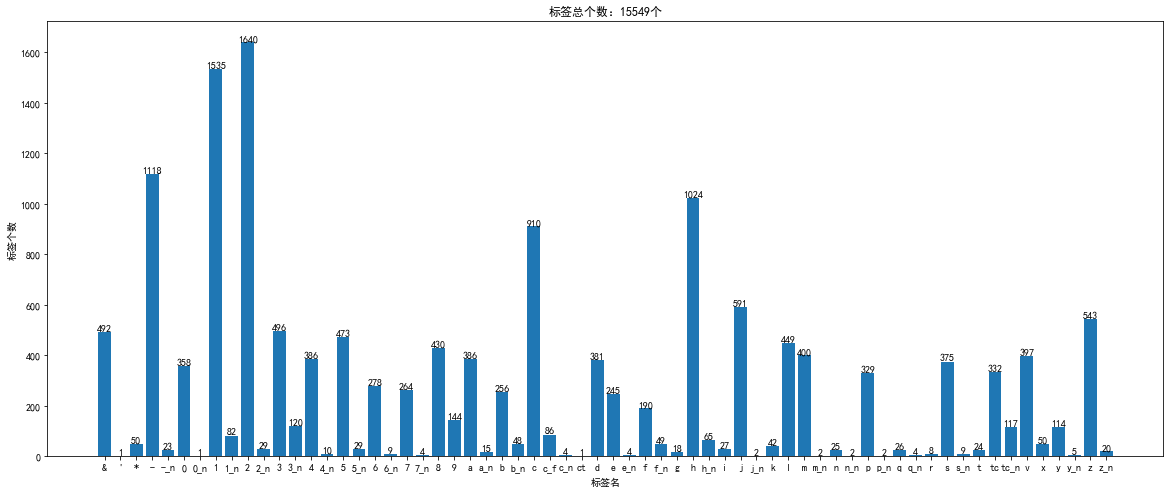

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize']=[20.0,8.0]#set default size of plots
plt.rcParams['image.interpolation']='nearest'#最近邻插值：像素为正方形
plt.rcParams['image.cmap']='gray'#使用灰度输出而不是彩色输出
plt.rcParams['font.sans-serif']=['SimHei']#显示中文标签

visualization(char_dic,save_name='所有类别的统计图1.png',verbose=True)

标签总个数：15549个


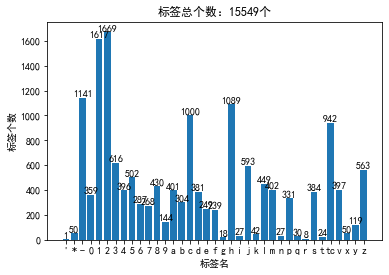

In [4]:
merged_dic={}
for idxs,numbers in char_dic.items():
    idx=idxs.split('_')[0]
    if idx not in merged_dic:
        merged_dic.setdefault(idx,numbers)
    else:
        merged_dic[idx]+=numbers
if 'ct' in merged_dic:
    merged_dic['tc']+=merged_dic['ct']
    del merged_dic['ct']
if '&' in merged_dic:
    merged_dic['tc']+=merged_dic['&']
    del merged_dic['&']
visualization(merged_dic, save_name='合并统计图.png')

标签总个数：15272个


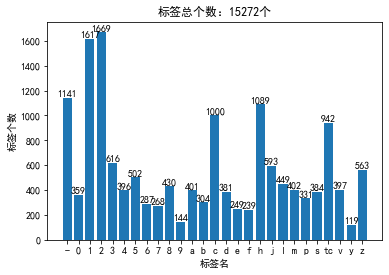

In [5]:
simplified_dic = merged_dic.copy()
new_dic = {}
for i, j in simplified_dic.items():
    if j > 50:
        new_dic[i] = j

visualization(new_dic, save_name='50阈值统计图.png')

In [6]:
import json
import json
import os.path

from skimage import io
import numpy as np
from labelme import utils


def get_labels_and_boxs(shapes):
    '''
    返回单个字符的标注框和标签信息
    输入shapes ：标准框信息
    '''
    label_box={}
    i=0
    for idx in range(len(shapes)):
        points=np.array(shapes[idx]['points']).astype(np.int32)#转换数组的数据类型
        label=shapes[idx]['label']
        label=label.split('_')[0]#标签，去除类似c_n这种标注
        label = label.replace('*','%') # 将字符串里的*全部替换成%
        label = label.replace(' ','') # 将字符串里的空格删除
        if label == 'box':#跳过老的标注框
            continue
        if label == 'tc' or label == 'ct':#修改老的标注
            label = '&'
        if len(label)>1 or label=="%":
            points_x=[min(points[:,0]),max(points[:,0])]
            points_y=[min(points[:,1]),max(points[:,1])]
            img_width=np.abs(points_x[0]-points_x[1])
            single_label_width=img_width//len(label)
            lab_points=np.array([[points_x[0],np.max(points_y)],[points_x[0]+single_label_width,np.min(points_y)]])#左上角和右下角的坐标，只适合矩形标注
            for lab in range(len(label)):
                label_box[i]=[label[lab],lab_points.copy()]#.copy复制更新后的，不然就一直是不更新状态下的
                i+=1
                lab_points[:,0]+=single_label_width#更新每个标签的坐标
        else:
            label_box[i]=[label,points]
            i+=1
    return label_box         
        

In [7]:
def img_crop(img,label_box):
    '''
    输入图片和标记信息，返回切割后的图片的集合。
    '''
    img_set={}
    for idx,item in label_box.items():
        label,points=item
        new_img=img[np.min(points[:,1]):np.max(points[:,1]),np.min(points[:,0]):np.max(points[:,0]),:]
        img_set[idx] = [label, new_img]
    return img_set

In [8]:
def img_generator(json_dir,output_dir,verbose=True):   
    '''
    输入json文件
    输出切割后的图片放到指定的文件夹
    '''
    json_file_list=os.listdir(json_dir)
    for i in range(len(json_file_list)):
        json_filename = json_file_list[i]
        if verbose:
                print('正在处理第{}张图片，文件名为{}'.format(i, json_filename))
        json_fullfile=os.path.join(json_dir,json_filename)
        with open(json_fullfile, 'r', encoding='utf8')as fp:
            json_data = json.load(fp)
        img = utils.img_b64_to_arr(json_data['imageData'])#解析原图片数据
        shapes = json_data['shapes']
        label_box=get_labels_and_boxs(shapes)
        img_set=img_crop(img,label_box)
        for j,(label, img) in img_set.items():
            filename = f'{label}_{json_filename[:-5]}_{j}.jpg'
            if not os.path.exists(os.path.join(output_dir, filename)):
                try:
                    #print(f'Creating {filename}')
                    io.imsave(os.path.join(output_dir, filename), img)
                except:
                    print('创建{}失败，数据来源{}。该标注可能不符合要求！'.format(filename, json_filename))
                    
            else:
                if verbose:
                    print(f'{filename} already existed!')



In [149]:
base = os.getcwd()
output_dir = os.path.join(base, 'data_cropped/')#输出图片位置
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
dir_list = [ '镀锌数据集标注', '角铁数据集标注']

for file in dir_list:
    print('正在处理:{}'.format(file[:-1]))
    json_dir = os.path.join(base, file)
    img_generator(json_dir, output_dir, verbose=False)

正在处理:镀锌数据集标


KeyboardInterrupt: 

In [11]:
from PIL import Image
def convertimg(file_path,out_path,width=128,height=256):
    '''
    图像转换大小函数
    输入：输入文件夹位置 输出文件夹位置
    '''
    file_path_image=os.listdir(file_path)
    if not os.path.exists(out_path):
        os.makedirs(out_path)
    for filename in file_path_image:
        filename=os.path.join(file_path,filename)
        img=Image.open(filename)
        new_img = img.resize((width, height))
        new_img.save(os.path.join(out_path, os.path.basename(filename)))
base_image_dir=os.getcwd()
file_path=os.path.join(base_image_dir,'data_cropped')
out_path=os.path.join(base_image_dir,'data_cropped_resize')
convertimg(file_path,out_path,width=64,height=128)

In [9]:
base = os.getcwd()
imgs_file = 'data_cropped/'
imgs_dir = os.path.join(base, imgs_file)#图片位置
gt_train = 'gt_train.txt'
gt_val = 'gt_val.txt'

imgs_list = os.listdir(imgs_dir)
print('图片张数：{}张'.format(len(imgs_list)))

data_dic = {}#键：标签；值：列表，列表内为属于该标签的所有图片历经，例如：[path/1.jpg,path/2.jpg]
train_dic = {}
val_dic = {}
label_col=set()
for img_name in imgs_list:
    label = img_name.split('_')[0]#得到标签
    label_col.add(label)
    data_dic.setdefault(label, [])#设定初始值为空列表
    data_dic[label].append(imgs_file + img_name)
label_col.remove("'")
print(sorted(label_col))
for label, x_list in data_dic.items():#将数据随机按0.92:0.08的比例分为训练集与验证集
    num = len(x_list)
    if num <=50:#样本太少的不加入验证集
        train_dic[label] = x_list
        continue
    mask = np.arange(num)
    np.random.shuffle(mask)#打乱数据
    train_idx = mask[:int(num*0.92)]
    val_idx = mask[int(num*0.92):]
    for idx in train_idx:
        train_dic.setdefault(label, [])#设定初始值为空列表
        train_dic[label].append(x_list[idx])
    for idx in val_idx:
        val_dic.setdefault(label, [])#设定初始值为空列表
        val_dic[label].append(x_list[idx])
del train_dic["'"]
with open(gt_train, "w") as f:#将train_dic的数据写入到记事本
    for label, train_list in train_dic.items():
        for img_dir in train_list:
            f.write('{}\t{}\n'.format(img_dir, label))

with open(gt_val, "w") as f:#将val_dic的数据写入到记事本
    for label, val_list in val_dic.items():
        for img_dir in val_list:
            f.write('{}\t{}\n'.format(img_dir, label))

图片张数：15549张
['%', '&', '-', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'v', 'x', 'y', 'z']


In [8]:
from PIL import Image
import pandas as pd
import os
import numpy as np
def load_img(file_path):
    # convertimg(file_path, out_path, width=128, height=256)#在同一目录下，图片转为设定的size
    #file_path图片路径
    file_path_image = os.listdir(file_path)
    label_train=[]
    label_val=[]
    image_train=[]
    image_val=[]
    image_train_num=0
    image_val_num=0
    all_images={}
    label_col=set()#统计类别
    for filename in file_path_image:
        all_label=filename.split("_")[0]
        label_col.add(all_label)
        all_images.setdefault(all_label, [])
        all_images[all_label].append(filename)
    for lab,imgdir in all_images.items():
        number=len(imgdir)
        if number<=50:
            for idx in range(number):
                filename=os.path.join(file_path,imgdir[idx])#路径
                imagefile=os.path.basename(filename)#图片文件名
                label=imagefile.split("_")[0]
                if label=="'":
                    continue
                else:
                    label_train.append(label)
                    img=Image.open(filename)
                    image_arr = np.array(img)
                    image_train.append(image_arr)   
        else:
            mask = np.arange(number)
            np.random.shuffle(mask)#打乱数据
            train_idx = mask[:int(number*0.92)]
            val_idx = mask[int(number*0.92):]
            for idx1 in train_idx:
                filename=os.path.join(file_path,imgdir[idx1])
                imagefile=os.path.basename(filename)#图片文件名
                label=imagefile.split("_")[0]
                label_train.append(label)
                img=Image.open(filename)
                image_arr = np.array(img)
                image_train.append(image_arr)
            for idx2 in val_idx:
                filename=os.path.join(file_path,imgdir[idx2])
                imagefile=os.path.basename(filename)#图片文件名
                label=imagefile.split("_")[0]
                label_val.append(label)
                img=Image.open(filename)
                image_arr = np.array(img)
                image_val.append(image_arr)
    image_val_num=len(image_val)
    image_train_num=len(image_train)
    #print(image_train_num)
    return image_train_num,image_val_num,image_train,image_val,label_train,label_val
    
def load_file(image_train_num,image_val_num,image_train,image_val,label_train,label_val,width=64,height=128):
    image_train_np=np.zeros((image_train_num,height,width,3))
    image_val_np=np.zeros((image_val_num,height,width,3))
    for i in range(image_train_num):
        image_train_np[i,:,:,:]=image_train[i]
#     for i in range(image_val_num):
#         image_val_np[i,:,:,:]=image_val[i]

    image_train_np=image_train_np.reshape((-1,height*width*3))
    image_val_np=image_val_np.reshape((-1,height*width*3))
    
    data1 = pd.DataFrame(image_train_np)
    data1.to_csv('train_data1.csv')
    labels_np=np.array(label_train)
    data2 = pd.DataFrame(labels_np)
    data2.to_csv('train_label1.csv')
    
#     data3 = pd.DataFrame(image_val_np)
#     data3.to_csv('val_data.csv')
#     labels_np1=np.array(label_val)
#     data4 = pd.DataFrame(labels_np1)
#     data4.to_csv('val_label.csv')
    
basedir=os.getcwd()
file_path=os.path.join(basedir,'data_cropped_resize')
image_train_num,image_val_num,image_train,image_val,label_train,label_val=load_img(file_path)
load_file(image_train_num,image_val_num,image_train,image_val,label_train,label_val,width=64,height=128)